In [48]:
# Data storage.
import pandas as pd 
import numpy as np 

# Visualization.
from matplotlib import pyplot as plt 
import seaborn as sns

# Preprocessing.
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor

# Models.
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Reading dataset and giving columns more understandable names.
data = pd.read_csv('https://raw.githubusercontent.com/udacity/machine-learning/master/projects/boston_housing/housing.csv')
data = data.rename(columns={'RM':'AVG_ROOMS', 'LSTAT':'LOWER_STATUS', 'PTRATIO':'STUDENT_TEACHER_RATIO', 'MEDV':'MED_VALUE'})

# Checking variable types and and for missing values.
# Features and label are continuous and dataset is complete.
print(data.info())

# Checking basic dataset measures. 
# Nothing glaring but more analysis to come. 
print('\n' + str(data.describe()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AVG_ROOMS              489 non-null    float64
 1   LOWER_STATUS           489 non-null    float64
 2   STUDENT_TEACHER_RATIO  489 non-null    float64
 3   MED_VALUE              489 non-null    float64
dtypes: float64(4)
memory usage: 15.4 KB
None

        AVG_ROOMS  LOWER_STATUS  STUDENT_TEACHER_RATIO     MED_VALUE
count  489.000000    489.000000             489.000000  4.890000e+02
mean     6.240288     12.939632              18.516564  4.543429e+05
std      0.643650      7.081990               2.111268  1.653403e+05
min      3.561000      1.980000              12.600000  1.050000e+05
25%      5.880000      7.370000              17.400000  3.507000e+05
50%      6.185000     11.690000              19.100000  4.389000e+05
75%      6.575000     17.120000              20.200000

### Exploratory Analysis

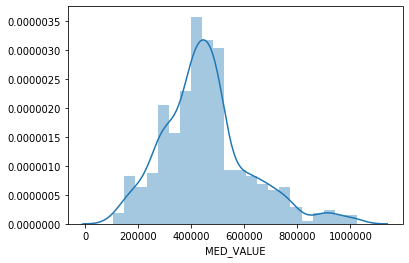

In [49]:
# Distribution of house price. 
sns.distplot(data['MED_VALUE'])
plt.show()

# Price Distribution Analysis:
# - Prices are slightly right skewed.
# - No strong outliers so we'll keep all our data. 

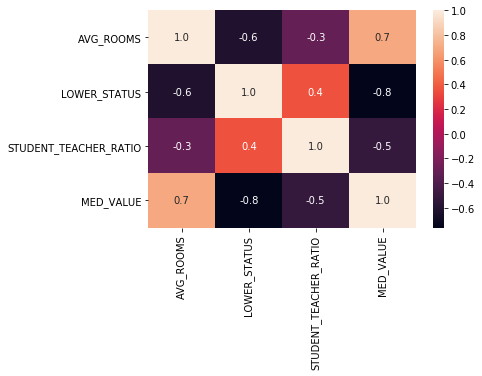

In [50]:
# Heatmap showing correlations between features.
sns.heatmap(data.corr(), annot=True, fmt='.1f')
plt.show()

# Heatmap Analysis:
# - Moderate correlations(.20-.40): Student_Teacher_Ratio x Avg_Rooms.
# - Strong correlations(.40+): The rest of them.
# - Basically all features are moderate/strong indictators of Median value and of eachother.

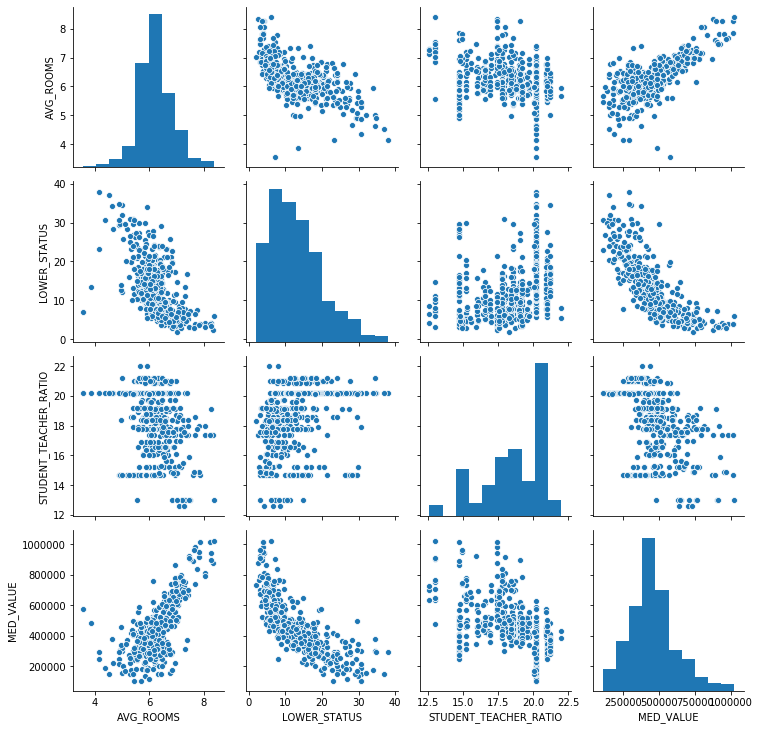

In [51]:
# Pairplot showing joint and marginal distributions.
sns.pairplot(data)
plt.show()

# Pairplot Analysis: 
# - Agv_Rooms and Lower_Status have strong positive and negative correlations with Median_Value.
# - These neighborhoods contain more lower status homeowners. 
# - Student_Teacher_Ratio is generally higher in these neighborhoods. 
# - Similar relationships found in heatmaps. 

### Data Preprocessing & Modelling
A pipeline is created that scales the data and then runs it through two regression algorithms. 
1. The first algorithm is basic linear regression. 
2. The second algorithm is a decision tree regressor.  

In [55]:
# Separating label and feature variables. 
y = data['MED_VALUE'][:-30]
x = data.drop(columns=['MED_VALUE'])[:-30]

# Separating out a validation set. 
y_val = data['MED_VALUE'][-30:]
x_val = data.drop(columns=['MED_VALUE'])[-30:]

# Splitting into training and test sets, keeping results reproducible.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# Pipeline will scale and model the data. 
pipeline = Pipeline(steps=[('feature_scaler', StandardScaler()),
                           ('regressor', LinearRegression())])

# Linear Regression model. 
pipeline.fit(x_train, y_train)
print(f'Linear Regression R^2 Score:{pipeline.score(x_test, y_test)}')

Linear Regression R^2 Score:0.7943056581990479


#### Linear Regression Analysis:
- Linear Regression gives an R^2 value of 0.79. Its okay but we can do better!


In [56]:
# Decision Tree Regressor.
pipeline.set_params(regressor=DecisionTreeRegressor())

# Parameters to tune.
h_params = {'regressor__max_depth': [1, 2, 3, 4, 5]}

reg = GridSearchCV(pipeline, h_params, cv=5)
reg.fit(x_train, y_train)
print(f'Decision Tree Regression R^2 Score:{reg.score(x_test, y_test)}')

Decision Tree Regression R^2 Score:0.8405691156204188


#### Decision Tree Regressor Analysis:
- Using Cross Validation to tune the decision tree regressor did significantly better than linear regression on its own. 
- scoring an R^2 value of 0.8405.
- The Decision tree regressor performed better because it is better at handling non-linearity. If the relationships between the features and price were more linear, then basic linear regression would perform better. 

#### Prediction on Validation Set:


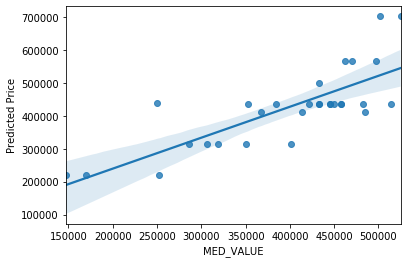

 Mean Squared Error: 6085114493.900306
 Mean Absolute Error: 56654.88270491675


In [57]:
price_predictions = pd.Series(reg.predict(x_val), name='Predicted Price')
sns.regplot(y_val, price_predictions)
plt.show()

print(f' Mean Squared Error: {mean_squared_error(y_val, price_predictions)}')
print(f' Mean Absolute Error: {mean_absolute_error(y_val, price_predictions)}')

# Validation Set Analysis: 
# - Although the mean absolute & squared error are high, the model
#   predicts most prices close to their actual values.

### POSSIBLE NEXT STEPS:
- The biggest issue with this project is the small dataset (490 total data points). Lowering the size of the test set from 30% to 10% of the dataset increased the the R^2 score by 0.05. Playing around with different test & validation sizes did cause slight fluctuations in the R^2.
- Run feature through PCA, and run principle components through the predictors. There might be latent features that perform better. 